In [1]:
## imports for the notebook
import import_ipynb
import os
import PVT_funcs as pvt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


importing Jupyter notebook from PVT_funcs.ipynb


# Basic material balance principles

The general form of the material balance equation was first presented by [Schilthuis](#refs) in 1941. The equation is derived as a volume balance which equates the cumulative observed production, expressed as an underground withdrawal, to the expansion of the fluids in the reservoir resulting from a finite pressure drop.

The majority of these examples and a more detailed explanation of their history and extension can also be found in [Dake's](#refs) textbook. We have followed their general thread here because it is quite logical in its layout.

To start with we will assume that we do not know anything about the volume of oil in the reservoir. This is a valid assumption because in reality we never know this (it is always just an estimate). However, we will see how powerful material balance is because we do not need to know this value to do some very useful calculations.

In [2]:
# initial setup
Pi=3109.4 #psia -- intial reservoir pressure, for the purposes of the following schematic we will start at bubble point
T=210.0 # deg F -- reservoir temperature (held constant through all of this)
res_porosity=0.23 # formation porosity
# some input fluid properties for the oil, gas and water to calculate required values
fluid_property_inputs={'api':35.0,
                  'gas_oil_ratio':620.0,
                  'gas_gravity':0.72,
                  'pressure':Pi,
                  'temperature':T,
                  'water_salinity':35000.0}
# create initial fluids
initial_oil=pvt.oil_properties(fluid_property_inputs)
initial_gas=pvt.gas_properties(fluid_property_inputs)
initial_water=pvt.water_properties(fluid_property_inputs)
# get the initial compressibility
cf=pvt.formation_compressibility(res_porosity)

N=1.0 # STB -- initial oil volume, conceptually the value of number makes no difference for the following demonstration
m=0.1 # ratio of initial gas cap volumn to initial oil volume
Swc=0.2 # connate water saturation, averaged for the whole reservoir
So=(1-Swc) # saturation of oil in the oil bearing zone of the reservoir
Sg=(1-Swc) # gas saturation in gas region
mNBoi=m*N*initial_oil['fvf']
V=(1+m)*N*initial_oil['fvf']/(res_porosity*(1-Swc)) # total volume of the reservoir system, all rock, water, oil and gas

Lets plot what that means in terms of volumes and how it evolves when we change the pressure using the following relationships:

liquid expansion: $$ N(B_o - B_{oi}) $$
liberated gas: $$ N(R_{si} - R_s)B_g $$
gas volume at new pressure: $$ mNB_{oi}\frac{B_g}{B_{gi}} $$

The change in the hydrocarbon pore volume is expressed as the expansion of the water and formation in the system:
$$ d(HCPV) = -(c_wV_w + c_fV_f) \Delta p $$

## simple reservoir pressure drop schematic

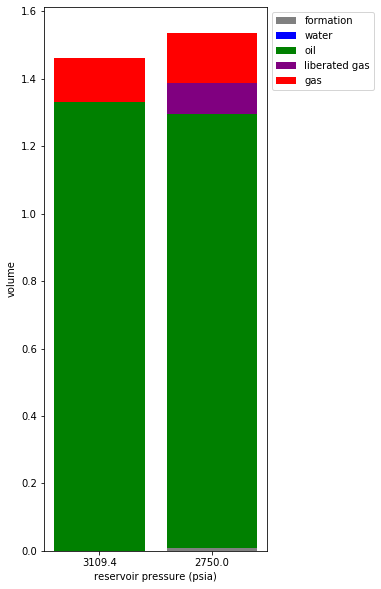

In [3]:
p=2750.0 # psia - reduced reservoir pressure
#calculate new properties at this pressure
fluid_property_inputs['pressure']=p
oil=pvt.oil_properties(fluid_property_inputs)
gas=pvt.gas_properties(fluid_property_inputs)
water=pvt.water_properties(fluid_property_inputs)

# calculate volumes to plot the changes
pressures=['{:.1f}'.format(Pi),'{:.1f}'.format(p)]
oil_volumes=[N*initial_oil['fvf'],N*oil['fvf']]
liberated_gas=[0.0,N*(initial_oil['solution_gas']-oil['solution_gas'])*gas['fvf']]
gas_volumes=[mNBoi,mNBoi*(gas['fvf']/initial_gas['fvf'])]
water_volume_change=[0.0,V*Swc*water['compressibility']*(Pi-p)]
formation_volume_change=[0.0,V*(1-res_porosity)*cf*(Pi-p)]

# now plot these volumes
fig=plt.figure(figsize=(4,10))
ax=fig.add_subplot(111)
ax.bar(pressures,formation_volume_change,label='formation',color='gray')
ax.bar(pressures,water_volume_change,bottom=formation_volume_change,label='water',color='blue')
bottoms=[x + y for x, y in zip(water_volume_change, formation_volume_change)]
ax.bar(pressures,oil_volumes,bottom=bottoms,label='oil',color='green')
bottoms=[x + y for x, y in zip(bottoms, oil_volumes)]
ax.bar(pressures,liberated_gas,bottom=bottoms,label='liberated gas',color='purple')
bottoms=[x + y for x, y in zip(bottoms, liberated_gas)]
ax.bar(pressures,gas_volumes,bottom=bottoms,label='gas',color='red')

# format
ax.set_xlabel('reservoir pressure (psia)')
ax.set_ylabel('volume')
ax.legend(loc='upper left',bbox_to_anchor=(1.0, 1.0))
plt.show()

We can see that the reservoir pressure dropping has resulted in an increase in the total volume of the system. Since the reservoir is bounded on all sides by rock, clearly it cannot 'grow' in size. The resulting extra volume is therefore assumed to have been removed from the reservoir in the form of production.

The observed production is given the name 'Np' and corresponds to the surface production of oil ('NpRp' is the gas produced).

So, we can equate these volumes at surface to the change in volume at the 'new' reservoir pressure (F):

$$ F = N_p(B_o+(R_p-R_s)B_g) $$

## Putting the whole thing together

Equating the underground withdrawl above with the expansion terms results in the material balance equation. This was first derived by [Schilthuis](#refs) in 1941 and is the basis for all of the techniques going forward in this introduction.
We introduce two terms here; cumulative water influx from an aquifer, (We); and cumulative water produced (Wp) these values are at stock tank conditions so we also need the water formation volume factor (Bw).

$$ N_p(B_o+(R_p-R_s)B_g) = NB_{oi} \left[ \frac{(B_o - B_{oi})+(R_{si} - R_s)B_g}{B_{oi}} + m\left(\frac{B_g}{B_{gi}} - 1\right) + (1+m) \left( \frac{c_wS_{wc}+c_f}{1-S_{wc}} \right) \Delta p \right] + (W_e - W_p)B_w $$

There are a few important limitations (or advantages) to this equation that should be mentioned at this point. 
1. it is zero dimensional, therefore it is simply evaluated at a point in the reservoir, all that is required is to define a reference depth and therefore a pressure. This should be consistent of the whole reservoir.
2. it is process independent, meaning that there is no time dependence to it. There are some aquifer influx models that are transient and therefore consider the path that they took to get to a certain pressure however for the basics we will assume that the pressure steps are instant and are at equilibrium when we do the calculations.
3. The only inputs are conceptually PVT (which is pressure dependant) and the production data, so these are things that are easily measured at surface with relatively high levels of accuracy.

## Drive mechanisms and recovery
Lets look at some drive mechanisms and some recovery calculations. We will quickly see that we actually do not need to know the volume of the reservoir to calculate the recovery that we will expect. (that might seem counter intuitive, however it is a simple calculation)
### Solution gas drive
Lets look at a reservoir under solution gas drive, for this we have to assume that there is no gas cap (i.e. the reservoir is above the bubble point). So m=0 in the above equations, this simplifies things down to: (we will ignore water influx and production)
$$ N_p B_o = NB_{oi} \left[ \frac{B_o - B_{oi}}{B_{oi}} + \frac{c_wS_{wc}+c_f}{1-S_{wc}} \Delta p \right] $$
If we define the compressibility of the oil as: $$ c_o=\frac{(B_o-B_{oi})}{B_{oi} \Delta p} $$
Then we can define the following equation: $$ N_pB_o=NB_{oi}c_e \Delta p $$
Where the total compressibility is: $$ c_e=\frac{1}{1-S_{wc}}(c_oS_o+c_wS_{wc}+c_f) $$
So lets calculate the fractional recovery of an undersaturated reservoir when it gets to the bubble point if we assume only solution gas drive as the mechanism.

In [4]:
# create initial fluids, using the properties above, just at a higher pressure
Pi=4500.0 #psia -- intial reservoir pressure, for the purposes of the following schematic we will above bubble point
p=3109.4 #psia -- bubble point pressure

# calculate initial reservoir fluid properties
fluid_property_inputs['pressure']=Pi
initial_oil=pvt.oil_properties(fluid_property_inputs)
initial_gas=pvt.gas_properties(fluid_property_inputs)
initial_water=pvt.water_properties(fluid_property_inputs)

#calculate new properties at this pressure
fluid_property_inputs['pressure']=p
oil=pvt.oil_properties(fluid_property_inputs)
gas=pvt.gas_properties(fluid_property_inputs)
water=pvt.water_properties(fluid_property_inputs)

cw=water['compressibility']
boi=initial_oil['fvf']
bo=oil['fvf']

co=(bo-boi)/(boi*(Pi-p))

print('formation compressibility: {:.3e}'.format(cf))
print('water saturation: {}'.format(Swc))
print('water compressibility: {:.3e}'.format(cw))
print('initial oil formation volume factor: {:.3f}'.format(boi))
print('bubble point oil formation volume factor: {:.3f}'.format(bo))
print('average oil compressibility: {:.3e}'.format(co))

ce=(1.0/(1.0-Swc))*(co*(1.0-Swc)+cw*Swc+cf)

print('\ntotal reservoir compressibility: {:.3e}'.format(ce))

formation compressibility: 3.327e-06
water saturation: 0.2
water compressibility: 3.167e-06
initial oil formation volume factor: 1.290
bubble point oil formation volume factor: 1.330
average oil compressibility: 2.223e-05

total reservoir compressibility: 2.718e-05


Recovery is simply the ratio of produced fluid to the total volume: $$ \frac{N_p}{N} $$ So, rearranging the equation above we get: $$ \frac{N_p}{N} = \frac{B_{oi}}{B_o}c_e \Delta p $$

In [5]:
recovery=boi/bo*ce*(Pi-p)
print('reservoir recovery at {:.1f} is {:.3}%'.format(p,recovery*100))

reservoir recovery at 3109.4 is 3.67%


So we do not get a lot of fluid out of the reservoir from simply solution expansion, this is to be expected because it shouldn't expand much (it is a liquid after all). However that is a lot of wasted energy since we have depleted the reservoir pressure by nearly 1400 psi.

### Solution gas drive below the bubble point

Lets take a look at the solution gas drive mechanism as we go below the bubble point pressure. We will make some simple assumptions here:
1. That there was no initial gas cap (as above)
2. There is no water drive or water influx from an aquifer
3. once we drop below the bubble point the total compressibility is dominated by the gas and oil and we iwll ignore the effect of water and formation. You can add it in later if you like...

so, looking back at our underground withdrawl idea and equation we get: $$ N_p(B_o+(R_p-R_s)B_g) = N ((B_o - B_{oi})+(R_{si} - R_s)B_g) $$
So we rearrange as above to get recovery: $$ recovery=\frac{N_p}{N}=\frac{(B_o - B_{oi})+(R_{si} - R_s)B_g}{B_o+(R_p-R_s)B_g} $$
So if we can determine an abandoment pressure we can calculate an ultimate recovery from the above relationship. Lets assume, for the sake of argument that we can lift fluid from the reservoir down to 1000.0 psia reservoir pressure. What will be the recovery?

In [6]:
#calculate new properties at this pressure
p=1000.0 # psia, abandonment pressure for the reservoir
fluid_property_inputs['pressure']=p
oil=pvt.oil_properties(fluid_property_inputs)
gas=pvt.gas_properties(fluid_property_inputs)
water=pvt.water_properties(fluid_property_inputs)

Rsi=initial_oil['solution_gas']
bo=oil['fvf']
Rs=oil['solution_gas']
Bg=gas['fvf']

# calculate Rp here, we will initially assume that we only lift solution gas, this is unrealistic in most case but we 
# see how this affects the recovery in a second
Rp=fluid_property_inputs['gas_oil_ratio']

recovery=((bo-boi)+(Rsi-Rs)*Bg)/(bo+(Rp-Rs)*Bg)
print('reservoir recovery at {:.1f} psia is {:.3}%'.format(p,recovery*100))

reservoir recovery at 1000.0 psia is 47.9%


That is a huge recovery in oil industry terms, so we can see that it is possible but lets look at the assumption that we made, we only produced at the initial gas oil ratio of the gas. This is unrealistic as gas is extremely mobile and will move towards the wells and break through when we produce. We can clearly see it is advantagous to leave as much gas in the reservoir as possible, however lets look at what the impact of increasing the produced gas ratio is to the recovery.

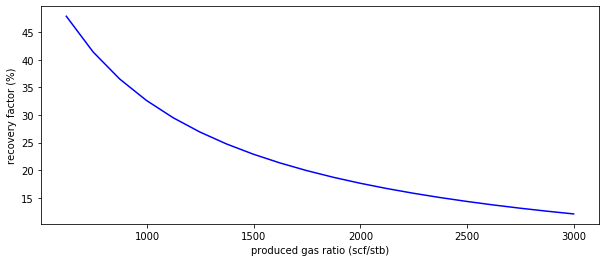

In [7]:
# create a function  that allows us to calculate the recovery as a function of produced gas ratio (Rp)
def calculate_recovery_from_Rp(_rp):
    return ((bo-boi)+(Rsi-Rs)*Bg)/(bo+(_rp-Rs)*Bg)*100.0

rps=np.linspace(start=Rp,stop=3000.0,num=20)
rfs=[calculate_recovery_from_Rp(r) for r in rps]

# now plot these volumes
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
ax.plot(rps,rfs,'b-')
ax.set_xlabel('produced gas ratio (scf/stb)')
ax.set_ylabel('recovery factor (%)')

plt.show()

## Calculating reservoir size and properties from material balance

Lets have a look now at using material balance to calculate the size of our reservoir. In this example the reservoir size and gas cap size are not known. All we know is the reservoir pressure and production history of oil and gas. [Havelena and Odeh](#refs) solved this issue in 1964 by rearranging the equations above by Schilthuis into: $$ \frac{F}{E_o}=N+mN \frac{E_g}{E_o} $$

In [8]:
Pi = 2985.6 # psia - starting with a reservoir at bubble point
T = 212.0 # deg F

# define fluid properties
fluid_property_inputs={'api':42.4,
                       'gas_oil_ratio':713.3,
                       'gas_gravity':0.692,
                       'pressure':Pi,
                       'temperature':T,
                       'water_salinity':18000.0}

oil=pvt.oil_properties(fluid_property_inputs)
gas=pvt.gas_properties(fluid_property_inputs)

# initial properties for the reservoir fluid
Boi=oil['fvf']
Bgi=gas['fvf']
Rsi=oil['solution_gas']

production_history_file=os.path.join(os.getcwd(),'_data','saturated_res_prod_history_1.pkl')
#production_history=pd.read_clipboard()
#production_history.to_pickle(production_history_file)
production_history=pd.read_pickle(production_history_file)
production_history.head()

,reservoir_pressure,Np,Rp
0,2985.616,0.0000,0.00
1,2975.706,0.3185,2141.00
2,2966.026,0.6370,2153.59
3,2956.306,0.9555,2166.34
4,2946.556,1.2740,2179.24


In [9]:
# insert the required values from the PVT properties
reservoir_pressures=production_history['reservoir_pressure']
Bos=[]
Rss=[]
Bgs=[]
for p in reservoir_pressures:
    fluid_property_inputs['pressure']=p
    oil=pvt.oil_properties(fluid_property_inputs)
    gas=pvt.gas_properties(fluid_property_inputs)
    Bos.append(oil['fvf'])
    Rss.append(oil['solution_gas'])
    Bgs.append(gas['fvf'])

# add them back into the dataframe for later
production_history['Bo']=np.array(Bos)
production_history['Rs']=np.array(Rss)
production_history['Bg']=np.array(Bgs)
production_history.head()

,reservoir_pressure,Np,Rp,Bo,Rs,Bg
0,2985.616,0.0000,0.00,1.380400,713.300000,0.001005
1,2975.706,0.3185,2141.00,1.378955,710.537355,0.001008
2,2966.026,0.6370,2153.59,1.377460,707.679855,0.001011
3,2956.306,0.9555,2166.34,1.375963,704.815265,0.001014
4,2946.556,1.2740,2179.24,1.374463,701.946578,0.001017


In [10]:
F=[]
Eo=[]
Eg=[]
for index, row in production_history.iterrows():
    F.append(row['Np']*(row['Bo']+(row['Rp']-row['Rs'])*row['Bg']))
    Eo.append((row['Bo']-Boi)+(Rsi-row['Rs'])*row['Bg'])
    Eg.append(Boi*((row['Bg']/Bgi)-1))

# add them back into the dataframe for later
production_history['F']=np.array(F)
production_history['Eo']=np.array(Eo)
production_history['Eg']=np.array(Eg)

# calculate Havlena and Odeh values
f_Eo=[x/y for x,y in zip(F,Eo)]
Eg_Eo=[x/y for x,y in zip(Eg,Eo)]
production_history['F_Eo']=np.array(f_Eo)
production_history['Eg_Eo']=np.array(Eg_Eo)

production_history.head()

,reservoir_pressure,Np,Rp,Bo,Rs,Bg,F,Eo,Eg,F_Eo,Eg_Eo
0,2985.616,0.0000,0.00,1.380400,713.300000,0.001005,0.000000,-1.568971e-07,-0.000007,-0.000000,42.335045
1,2975.706,0.3185,2141.00,1.378955,710.537355,0.001008,0.898299,1.338579e-03,0.004124,671.084071,3.080848
2,2966.026,0.6370,2153.59,1.377460,707.679855,0.001011,1.808288,2.740215e-03,0.008191,659.907181,2.989164
3,2956.306,0.9555,2166.34,1.375963,704.815265,0.001014,2.730263,4.163027e-03,0.012307,655.835957,2.956305
4,2946.556,1.2740,2179.24,1.374463,701.946578,0.001017,3.664504,5.605887e-03,0.016469,653.688607,2.937823


N = 298.23 MMstb, and m = 0.41


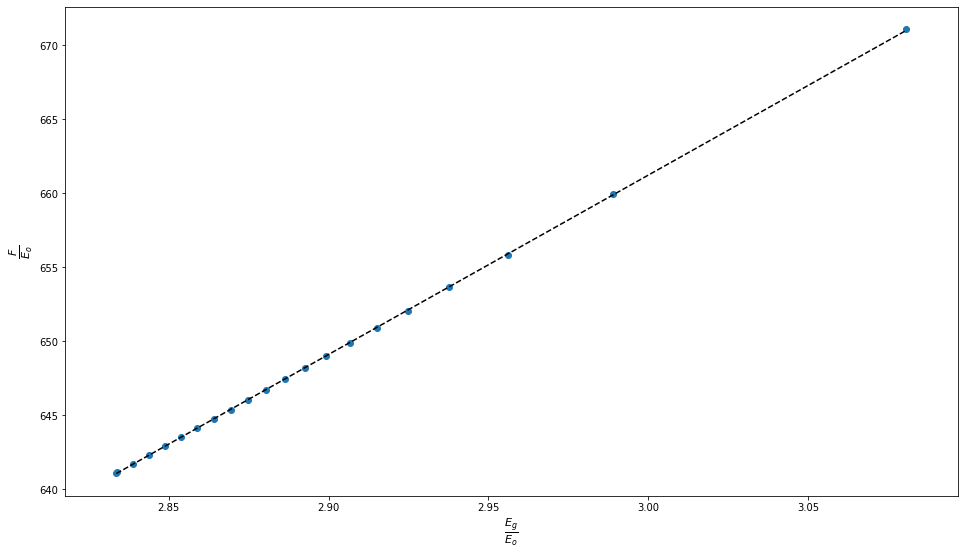

In [11]:
# now plot this data
data=production_history[1:]

# fit data to linear trend
history_match = np.polyfit(data['Eg_Eo'], data['F_Eo'], 1)
N=history_match[1]
m=history_match[0]/history_match[1]
print('N = {:.2f} MMstb, and m = {:.2f}'.format(N,m))

x=np.linspace(data['Eg_Eo'].min(),data['Eg_Eo'].max())
y=N+m*N*x

fig=plt.figure(figsize=(16,9))
ax=fig.add_subplot(111)
ax.scatter(data['Eg_Eo'],data['F_Eo'])
ax.plot(x,y,'k--')
ax.set_xlabel(r'$\frac{E_g}{E_o}$',fontsize=16)
ax.set_ylabel(r'$\frac{F}{E_o}$',fontsize=16)

plt.show()

## Calculating anticipated recovery
Lets use the relationships above to calculate the ultimate recovery we can expect. We assume that we can produce this reservoir down to a reservoir pressure of 1500.0 psia, so what would the recovery be at that point?

In [12]:
abandonment_pressure=1500.0 # psia
fluid_property_inputs['pressure']=abandonment_pressure
oil=pvt.oil_properties(fluid_property_inputs)
gas=pvt.gas_properties(fluid_property_inputs)
bo=oil['fvf']
Rs=oil['solution_gas']
Bg=gas['fvf']
Rp=production_history['Rp'].max()
# we will use the Rp from the history data, this will be optimistic
recovery=((bo-boi)+(Rsi-Rs)*Bg)/(bo+(Rp-Rs)*Bg)
print('reservoir recovery at {:.1f} psia is {:.3}%'.format(abandonment_pressure,recovery*100))

reservoir recovery at 1500.0 psia is 12.6%


That recovery is quite low, lets use the relationship we have for underground withdrawl (**F**) to see if we can improve things.

One option that is well known and understood in reservoir engineering is water injection. Perhaps we can inject water to keep the reservoir pressure above the abandonment pressure and produce for longer. Lets see how much water we would have to inject to keep the reservoir pressure approximately where it is now.

Using 1 stb of fluid as a basis the equation for **F** becomes: $$ F=B_o+(R_p-R_s)B_g $$

In [13]:
current_reservoir_pressure=data['reservoir_pressure'].min()
fluid_property_inputs['pressure']=current_reservoir_pressure
oil=pvt.oil_properties(fluid_property_inputs)
gas=pvt.gas_properties(fluid_property_inputs)
water=pvt.water_properties(fluid_property_inputs)
bo=oil['fvf']
Rs=oil['solution_gas']
Bg=gas['fvf']
bw=water['fvf']
f=bo+(Rp-Rs)*Bg
f_surface=f*bw
print('for every stb oil produced we have to inject {:.2f} stb of water'.format(f_surface))

for every stb oil produced we have to inject 3.33 stb of water


## References

<a id="refs"></a>
1. Schilthuis, R.J., 1936. Active Oil and Reservoir Energy. Trans., AIME, 118: 33-52.
2. Dake, L., 1983. Fundamentals of Reservoir Engineering., Ch. 3, Elsevier Science.
3. Havlena, D. and Odeh, A.S., 1963. The Material Balance as an Equation of a Straight Line. J.Pet.Tech. August: 896-900. Trans., AIME, 228.